# Subspace Inference with Advanced MH Sampler

### use packages

In [1]:
using NPZ
using Flux
using Flux: Data.DataLoader
using Flux: @epochs
using BSON: @save
using BSON: @load
using Zygote
using PyPlot
using SubspaceInference;

### Set working directory

In [2]:
root = pwd();
cd(root);

### Load Data and Format

In [3]:
data_ld = npzread("data.npy");
x, y = (data_ld[:, 1]', data_ld[:, 2]');
function features(x)
    return vcat(x./2, (x./2).^2)
end

f = features(x);
data =  DataLoader(f,y, batchsize=50, shuffle=true);

### Setup NN model

In [4]:
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)


θ, re = Flux.destructure(m);

L(m, x, y) = Flux.Losses.mse(m(x), y)/2;
ps = Flux.params(m);
opt = Momentum(0.01, 0.95);

### Pretrain model

In [5]:
## update cost function to suite for flux training
#L(x, y) = Flux.Losses.mse(m(x), y)/2;
#@epochs 3000 Flux.train!(L, ps, data, opt)

This notebook, we are using a pretrained model

In [6]:
i = 1;
@load "model_weights_$(i).bson" ps;
Flux.loadparams!(m, ps);

### Run subspace inference

In [9]:
M = 20
T = 25
c = 1
itr = 10_00

chn, lp, W_swa, re = SubspaceInference.subspace_inference(m, L, data, opt,
	σ_z = 1.0,	σ_m = 1.0, σ_p = 1.0,
	itr =itr, T=T, c=c, M=M, print_freq=5
);

Traing loss: 0.0016628034738906461 Epoch: 5
Traing loss: 0.0018738324803927143 Epoch: 10
Traing loss: 0.0010192760299688785 Epoch: 15
Traing loss: 0.0008885469747207875 Epoch: 20
Traing loss: 0.0013429274640125576 Epoch: 25

Sampling:   4%|██                                       |  ETA: 0:00:02

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


### Plot Uncertainty

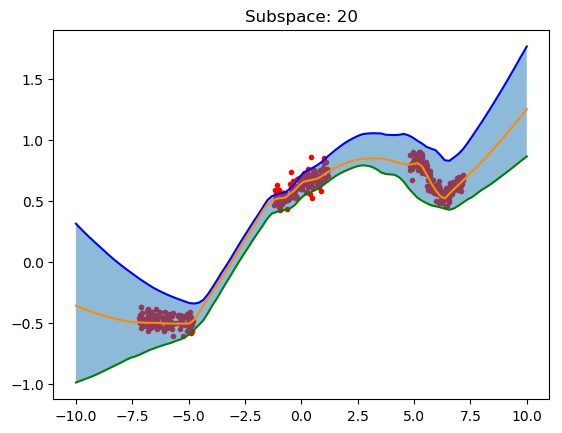

In [11]:
ns = length(chn)
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,ns)
for i in 1:ns
	mn = re(chn[i])
	out = mn(inp)
	trajectories[:, i] = out'
end

mx = maximum(trajectories, dims=2)
mn = minimum(trajectories, dims=2)
val, loc = findmax(lp)
max_log = trajectories[:,loc]
(fig, f_axes) = PyPlot.subplots(ncols=1, nrows=1)
f_axes.scatter(data_ld[:,1],data_ld[:,2], c="red", marker=".")
f_axes.plot(z,vec(mx), c="blue") #maximum values
f_axes.plot(z,vec(mn), c="green") #minimum values
f_axes.plot(z,vec(max_log), c="darkorange") #maximum log probability
f_axes.fill_between(z, vec(mx), vec(mn), alpha=0.5)
f_axes.set_title("Subspace: 20")
fig.show()

### Run subspace inference for subspze size of 50

Traing loss: 0.0014269247162112463 Epoch: 5
Traing loss: 0.0013888619831137028 Epoch: 10
Traing loss: 0.0010353327408136259 Epoch: 15
Traing loss: 0.0013416970680069885 Epoch: 20
Traing loss: 0.0008690291248972848 Epoch: 25
Traing loss: 0.0009938663735832166 Epoch: 30
Traing loss: 0.0010501309035283236 Epoch: 35
Traing loss: 0.001424887991998265 Epoch: 40
Traing loss: 0.0011398893161968893 Epoch: 45
Traing loss: 0.001176458304718544 Epoch: 50
Traing loss: 0.000686573762823297 Epoch: 55


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


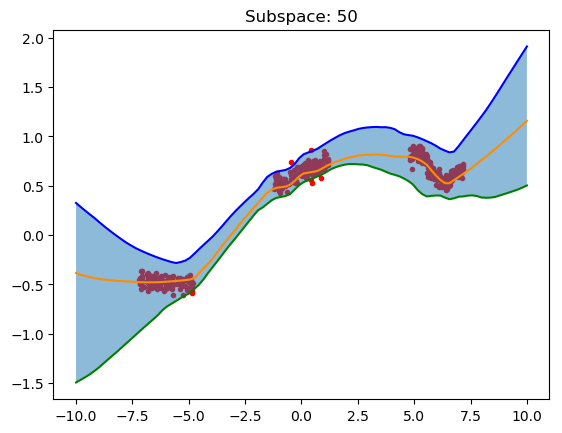

In [13]:
i = 1;
@load "model_weights_$(i).bson" ps;
Flux.loadparams!(m, ps);

M = 50
T = 55
c = 1
itr = 10_00

chn, lp, W_swa, re = SubspaceInference.subspace_inference(m, L, data, opt,
	σ_z = 1.0,	σ_m = 1.0, σ_p = 1.0,
	itr =itr, T=T, c=c, M=M, print_freq=5
);

ns = length(chn)
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,ns)
for i in 1:ns
	mn = re(chn[i])
	out = mn(inp)
	trajectories[:, i] = out'
end

mx = maximum(trajectories, dims=2)
mn = minimum(trajectories, dims=2)
val, loc = findmax(lp)
max_log = trajectories[:,loc]
(fig, f_axes) = PyPlot.subplots(ncols=1, nrows=1)
f_axes.scatter(data_ld[:,1],data_ld[:,2], c="red", marker=".")
f_axes.plot(z,vec(mx), c="blue") #maximum values
f_axes.plot(z,vec(mn), c="green") #minimum values
f_axes.plot(z,vec(max_log), c="darkorange") #maximum log probability
f_axes.fill_between(z, vec(mx), vec(mn), alpha=0.5)
f_axes.set_title("Subspace: 50")
fig.show()